In [1]:
import sys
sys.path.append('/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities')

import re
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.sparse

import matplotlib.pyplot as plt
from matplotlib import __version__ as mpl_version

import seaborn as sns

In [2]:
print(sys.version)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('matplotlib', mpl_version)
print('seaborn', sns.__version__)

3.8.2 (default, May 23 2020, 03:35:41) 
[Clang 11.0.3 (clang-1103.0.32.62)]
numpy 1.19.2
pandas 1.1.2
scipy 1.4.1
matplotlib 3.3.2
seaborn 0.11.0


In [3]:
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams

params = {'pdf.fonttype': 42,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'mathtext.default': 'regular',
          'figure.dpi': 96 * 1.5,
          'axes.axisbelow': True}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [4]:
from utilities import (
    read_10x_matrix,
    calc_mt_percentage,
    plot_barplot_mt_distribution
)

# Preparation

In [5]:
def load_10x_matrix(data_dir,
                    cell_id_prefix,
                    cells_included_file=None,
                    add_prefix_for_cells_included=True):

    matrix_dir = data_dir / cell_id_prefix / 'filtered_feature_bc_matrix'
    cell_id_prefix = cell_id_prefix.split('_')[0]

    matrix_readcount_raw = read_10x_matrix(
        data_directory=matrix_dir,
        cell_id_prefix=cell_id_prefix,
        features_selected='Gene Expression',
    )

    # select cells
    if cells_included_file:
        if cell_id_prefix:

            if add_prefix_for_cells_included:
                cells_included = [cell_id_prefix + '_' + i.rstrip().replace('-1', '')
                                  for i in open(file=cells_included_file, mode='r')]
            else:
                cells_included = [i.rstrip().replace('-1$', '')
                                  for i in open(file=cells_included_file, mode='r')]

        else:
            cells_included = [i.rstrip().replace('-1', '')
                              for i in open(file=cells_included_file, mode='r')]

        cells_included_idx, = np.where(
            np.isin(
                element=matrix_readcount_raw['barcodes'],
                test_elements=cells_included
            )
        )
        matrix_readcount_raw['matrix'] = \
            matrix_readcount_raw['matrix'][:, cells_included_idx]
        matrix_readcount_raw['barcodes'] = \
            matrix_readcount_raw['barcodes'][cells_included_idx]

    return matrix_readcount_raw

In [6]:
from functools import reduce


def merge_matrices(a, b):
    m = scipy.sparse.hstack(
        blocks=(a, b),
        format=None, dtype=np.int_).tocsc()

    return m

In [7]:
def save_matrice(directory):

    directory = Path(directory)

    file_name = directory / 'matrix_readcount.npz'
    if not file_name.is_file():
        scipy.sparse.save_npz(
            file=file_name,
            matrix=matrix_readcount_use,
            compressed=True
        )

    file_name = directory / 'matrix_readcount_barcodes.npy'
    if not file_name.is_file():
        np.save(
            file=file_name,
            arr=matrix_readcount_use_barcodes.astype(dtype=np.unicode_),
            allow_pickle=False
        )

    file_name = directory / 'matrix_readcount_features.npy'
    if not file_name.is_file():
        np.save(
            file=file_name,
            arr=matrix_readcount_use_features.astype(dtype=np.unicode_),
            allow_pickle=False
        )

In [8]:
DATA_DIR = Path('/Users/jialei/Dropbox/Data/Projects/UTSW/Human_blastoid/raw')

In [9]:
MT_PERCENTAGE_CUTOFF = 0.2

# Batch: LW36

## Loading matrices

In [10]:
library_ids = ['LW36']

In [11]:
cells_scrublet = ['cells_singlet_log_0.235_9129_637.txt']

In [12]:
matrices = list()

In [13]:
for i, j in zip(library_ids, cells_scrublet):
    print(i)
    print(j)

    m = load_10x_matrix(
        data_dir=DATA_DIR,
        cell_id_prefix=i,
        cells_included_file=DATA_DIR / i / 'scrublet' / j
    )
    matrices.append(m)

    print(m['matrix'].shape)

LW36
cells_singlet_log_0.235_9129_637.txt
(33538, 9129)


In [14]:
matrix_readcount_use = reduce(merge_matrices, [i['matrix'] for i in matrices])

In [15]:
matrix_readcount_use_barcodes = np.concatenate(
    [i['barcodes'] for i in matrices], axis=0)
matrix_readcount_use_features = matrices[0]['features']

In [16]:
assert matrix_readcount_use.shape == (len(matrix_readcount_use_features),
                                      len(matrix_readcount_use_barcodes))

In [17]:
del matrices

## Saving matrices

In [18]:
BATCH_ID = 'LW36'

In [19]:
DATA_DIR_MATRICES = Path('../data/matrices') / BATCH_ID
DATA_DIR_MATRICES.mkdir(exist_ok=True)

In [20]:
save_matrice(directory=DATA_DIR_MATRICES)

<AxesSubplot:xlabel='Percentage of MT UMI counts', ylabel='Number of cells'>

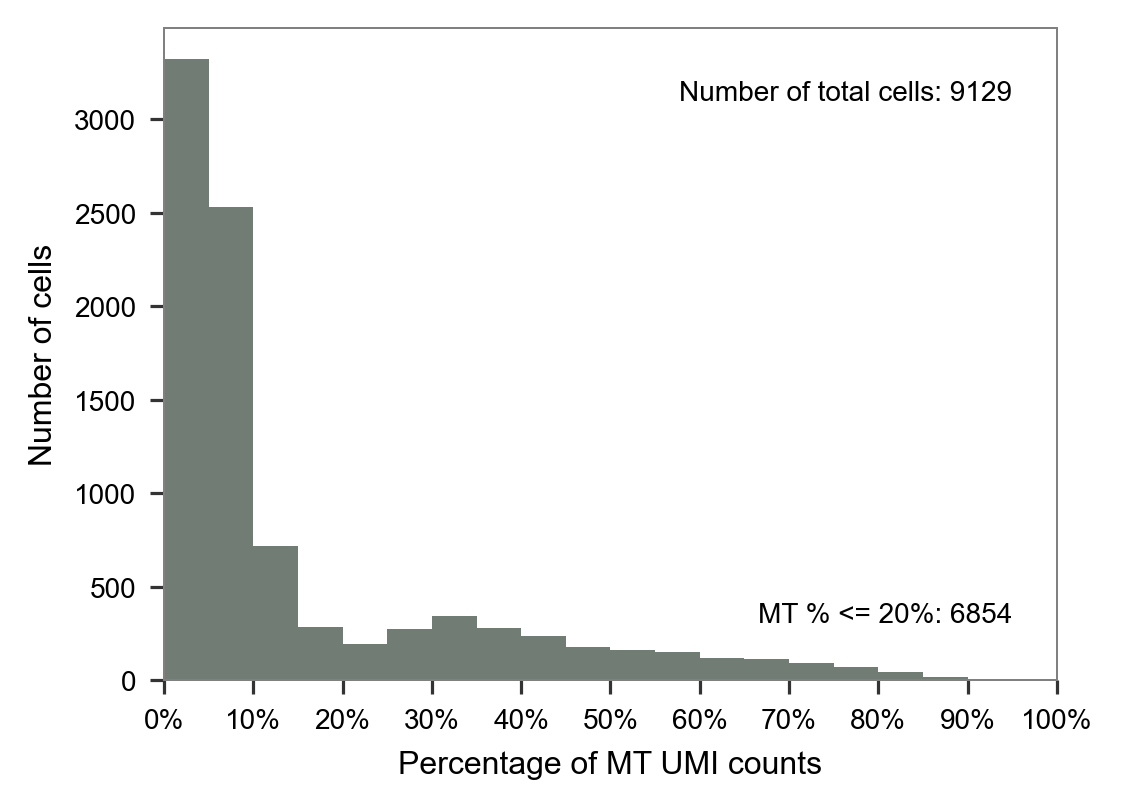

In [21]:
mt_ratio = calc_mt_percentage(
    matrix=matrix_readcount_use,
    features=matrix_readcount_use_features
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))
plot_barplot_mt_distribution(x=mt_ratio, ax=ax)

In [22]:
file_name = DATA_DIR_MATRICES / 'cells_passed_mt_filtering.txt'

if not file_name.is_file():
    _, = np.where(mt_ratio <= MT_PERCENTAGE_CUTOFF)
    np.savetxt(fname=file_name,
               X=matrix_readcount_use_barcodes[_],
               delimiter='',
               fmt='%s')

# Batch: LW58_LW59

## Loading matrices

In [23]:
library_ids = [
    'LW58',
    'LW59'
]

In [24]:
cells_scrublet = [
    'cells_singlet_log_0.162_5628_874.txt',
    'cells_singlet_log_0.174_5494_626.txt'
]

In [25]:
matrices = list()

In [26]:
for i, j in zip(library_ids, cells_scrublet):
    print(i)
    print(j)

    m = load_10x_matrix(
        data_dir=DATA_DIR,
        cell_id_prefix=i,
        cells_included_file=DATA_DIR / i / 'scrublet' / j
    )
    matrices.append(m)

    print(m['matrix'].shape)

LW58
cells_singlet_log_0.162_5628_874.txt
(33538, 5628)
LW59
cells_singlet_log_0.174_5494_626.txt
(33538, 5494)


In [27]:
matrix_readcount_use = reduce(merge_matrices, [i['matrix'] for i in matrices])

In [28]:
matrix_readcount_use_barcodes = np.concatenate(
    [i['barcodes'] for i in matrices], axis=0)
matrix_readcount_use_features = matrices[0]['features']

In [29]:
assert matrix_readcount_use.shape == (len(matrix_readcount_use_features),
                                      len(matrix_readcount_use_barcodes))

In [30]:
del matrices

## Saving matrices

In [31]:
BATCH_ID = 'LW58_LW59'

In [32]:
DATA_DIR_MATRICES = Path('../data/matrices') / BATCH_ID
DATA_DIR_MATRICES.mkdir(exist_ok=True)

In [33]:
save_matrice(directory=DATA_DIR_MATRICES)

<AxesSubplot:xlabel='Percentage of MT UMI counts', ylabel='Number of cells'>

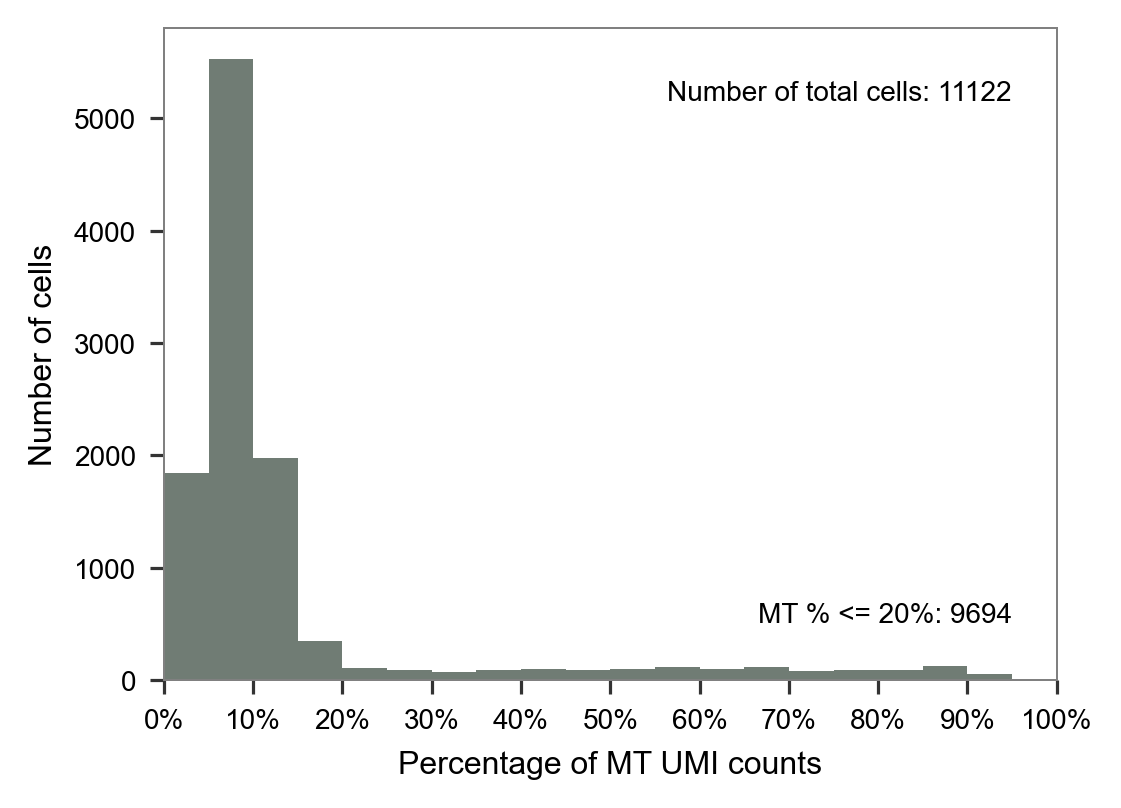

In [34]:
mt_ratio = calc_mt_percentage(
    matrix=matrix_readcount_use,
    features=matrix_readcount_use_features
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))
plot_barplot_mt_distribution(x=mt_ratio, ax=ax)

In [35]:
file_name = DATA_DIR_MATRICES / 'cells_passed_mt_filtering.txt'

if not file_name.is_file():
    _, = np.where(mt_ratio <= MT_PERCENTAGE_CUTOFF)
    np.savetxt(fname=file_name,
               X=matrix_readcount_use_barcodes[_],
               delimiter='',
               fmt='%s')

# Batch: LW60_LW61

## Loading matrices

In [36]:
library_ids = [
    'LW60',
    'LW61'
]

In [37]:
cells_scrublet = [
    'cells_singlet_log_0.196_5512_189.txt',
    'cells_singlet_log_0.195_6611_707.txt'
]

In [38]:
matrices = list()

In [39]:
for i, j in zip(library_ids, cells_scrublet):
    print(i)
    print(j)

    m = load_10x_matrix(
        data_dir=DATA_DIR,
        cell_id_prefix=i,
        cells_included_file=DATA_DIR / i / 'scrublet' / j
    )
    matrices.append(m)

    print(m['matrix'].shape)

LW60
cells_singlet_log_0.196_5512_189.txt
(33538, 5512)
LW61
cells_singlet_log_0.195_6611_707.txt
(33538, 6611)


In [40]:
matrix_readcount_use = reduce(merge_matrices, [i['matrix'] for i in matrices])

In [41]:
matrix_readcount_use_barcodes = np.concatenate(
    [i['barcodes'] for i in matrices], axis=0)
matrix_readcount_use_features = matrices[0]['features']

In [42]:
assert matrix_readcount_use.shape == (len(matrix_readcount_use_features),
                                      len(matrix_readcount_use_barcodes))

In [43]:
del matrices

## Saving matrices

In [44]:
BATCH_ID = 'LW60_LW61'

In [45]:
DATA_DIR_MATRICES = Path('../data/matrices') / BATCH_ID
DATA_DIR_MATRICES.mkdir(exist_ok=True)

In [46]:
save_matrice(directory=DATA_DIR_MATRICES)

<AxesSubplot:xlabel='Percentage of MT UMI counts', ylabel='Number of cells'>

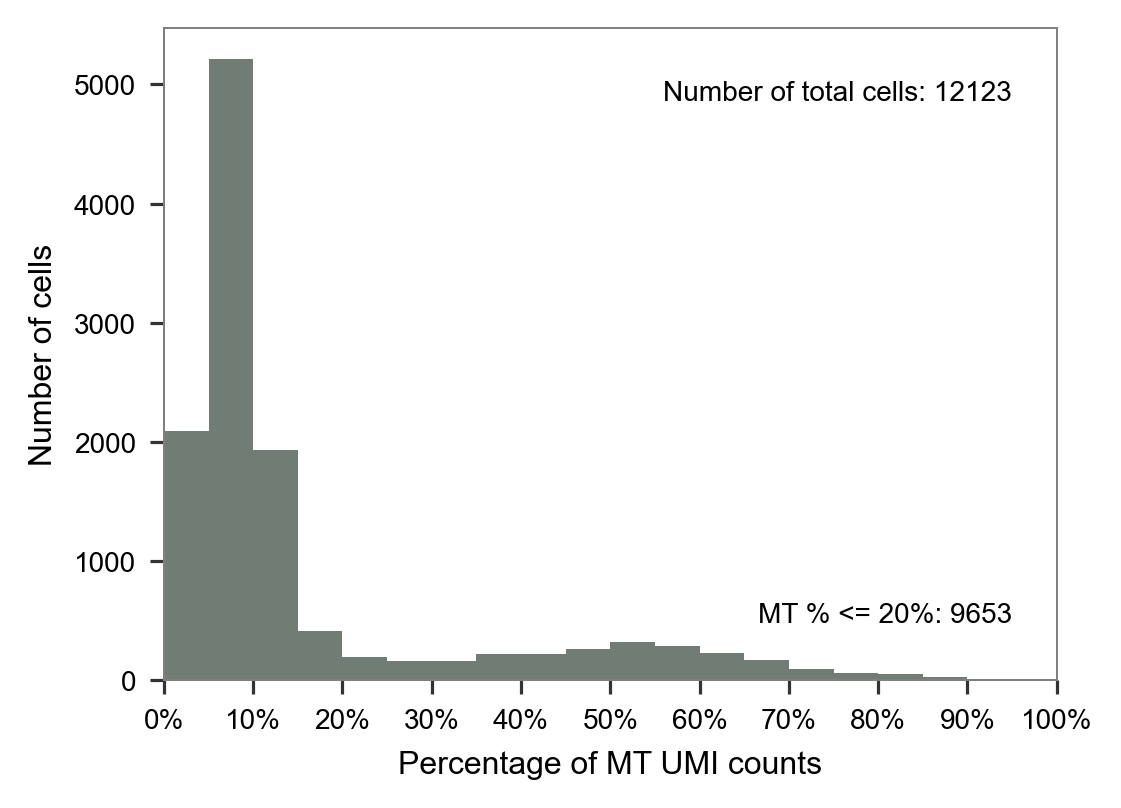

In [47]:
mt_ratio = calc_mt_percentage(
    matrix=matrix_readcount_use,
    features=matrix_readcount_use_features
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))
plot_barplot_mt_distribution(x=mt_ratio, ax=ax)

In [48]:
file_name = DATA_DIR_MATRICES / 'cells_passed_mt_filtering.txt'

if not file_name.is_file():
    _, = np.where(mt_ratio <= MT_PERCENTAGE_CUTOFF)
    np.savetxt(fname=file_name,
               X=matrix_readcount_use_barcodes[_],
               delimiter='',
               fmt='%s')

# Batch: LW49_LW50_LW51_LW52

## Loading matrices

In [49]:
library_ids = [
    'LW49',
    'LW50',
    'LW51',
    'LW52'
]

In [50]:
matrices = list()

In [51]:
for i in library_ids:
    print(i)

    m = load_10x_matrix(
        data_dir=DATA_DIR,
        cell_id_prefix=i,
        cells_included_file=DATA_DIR /
        'feeder_cell_detection/filtered_feature_bc_matrix_scrublet/clustering/LW49_LW50_LW51_LW52/cells_included.txt',
        add_prefix_for_cells_included=False
    )
    matrices.append(m)

    print(m['matrix'].shape)

LW49
(33538, 1638)
LW50
(33538, 2663)
LW51
(33538, 2055)
LW52
(33538, 4486)


In [52]:
matrix_readcount_use = reduce(merge_matrices, [i['matrix'] for i in matrices])

In [53]:
matrix_readcount_use_barcodes = np.concatenate(
    [i['barcodes'] for i in matrices], axis=0)
matrix_readcount_use_features = matrices[0]['features']

In [54]:
assert matrix_readcount_use.shape == (len(matrix_readcount_use_features),
                                      len(matrix_readcount_use_barcodes))

In [55]:
del matrices

## Saving matrices

In [56]:
BATCH_ID = 'LW49_LW50_LW51_LW52'

In [57]:
DATA_DIR_MATRICES = Path('../data/matrices') / BATCH_ID
DATA_DIR_MATRICES.mkdir(exist_ok=True)

In [58]:
save_matrice(directory=DATA_DIR_MATRICES)

<AxesSubplot:xlabel='Percentage of MT UMI counts', ylabel='Number of cells'>

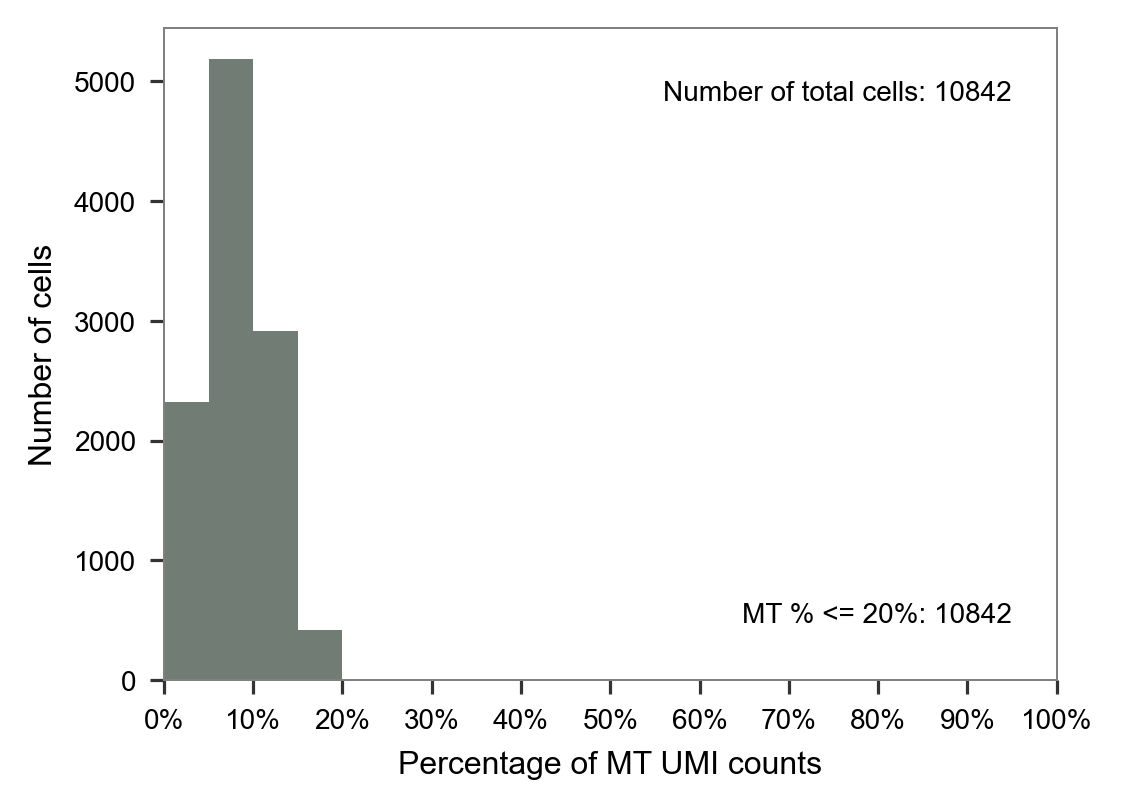

In [59]:
mt_ratio = calc_mt_percentage(
    matrix=matrix_readcount_use,
    features=matrix_readcount_use_features
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))
plot_barplot_mt_distribution(x=mt_ratio, ax=ax)

In [60]:
file_name = DATA_DIR_MATRICES / 'cells_passed_mt_filtering.txt'

if not file_name.is_file():
    _, = np.where(mt_ratio <= MT_PERCENTAGE_CUTOFF)
    np.savetxt(fname=file_name,
               X=matrix_readcount_use_barcodes[_],
               delimiter='',
               fmt='%s')